# 0.0 Imports

In [1]:
import numpy   as np
import pandas  as pd
import seaborn as sns

from IPython.display import HTML
from matplotlib import pyplot as plt

from operator        import attrgetter
import warnings

## 0.1 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings('ignore')

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Dataset

In [3]:
# load data
df_raw = pd.read_csv( '/home/deivison/Documentos/projetos/desafio_ds/desafio_1/dataset/Ecommerce.csv', encoding = 'unicode_escape')
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.00,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.00,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.00,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.00,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.00,United Kingdom


# 1.0 Descrição dos Dados

In [4]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [5]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = cols_new

## 1.2 Data Dimensions

In [6]:
print( 'Number of rows: {}'.format( df1.shape[0] ) )
print( 'Number of cols: {}'.format( df1.shape[1] ) )

Number of rows: 541909
Number of cols: 8


## 1.3 Data Types

In [7]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Check NA

In [8]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

In [9]:
print( "Porcentagem de NA's na variável 'customer_id' = {:.2f} %".format( (df1['customer_id'].isna().sum() / df1.shape[0] ) * 100 ) ) 

Porcentagem de NA's na variável 'customer_id' = 24.93 %


## 1.5 Replace NA

In [10]:
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

In [11]:
# create reference --> pegou os cupons fiscais unicos com vazios
df_backup = pd.DataFrame( df_missing['invoice_no'].drop_duplicates() )
df_backup['customer_id'] = np.arange( 19000, 19000+len( df_backup ), 1)

# merge original with reference dataframe
df1 = pd.merge( df1, df_backup, on='invoice_no', how='left' )

In [12]:
df1[['invoice_no','customer_id_x','customer_id_y']].sample(20)

,invoice_no,customer_id_x,customer_id_y
389182,570465,NaN,21977.00
438039,574304,14428.00,NaN
346781,567204,15365.00,NaN
467503,576351,17235.00,NaN
118950,546502,16005.00,NaN
460526,575919,15311.00,NaN
362395,568471,17805.00,NaN
479583,577171,17159.00,NaN
76796,542649,17373.00,NaN
162082,550496,NaN,20347.00


In [13]:
# coalesce 
df1['customer_id'] = df1['customer_id_x'].combine_first( df1['customer_id_y'] )

# drop extra columns
df1 = df1.drop( columns=['customer_id_x', 'customer_id_y'], axis=1 )

In [14]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

In [15]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,United Kingdom,17850.00
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,United Kingdom,17850.00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,United Kingdom,17850.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,United Kingdom,17850.00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,United Kingdom,17850.00


## 1.6 Change Types

In [16]:
# invoice date
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'] )
df1['invoice_hour'] = df1['invoice_date'].dt.strftime('%H')
df1['invoice_hour'] = df1['invoice_hour'].astype( int )
df1['invoice_date'] = df1['invoice_date'].dt.strftime('%Y-%m-%d')
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'] )
# customer id
df1['customer_id'] = df1['customer_id'].astype( int )
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id,invoice_hour
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,United Kingdom,17850,8
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,United Kingdom,17850,8
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,United Kingdom,17850,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,United Kingdom,17850,8
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,United Kingdom,17850,8


In [17]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
invoice_hour             int64
dtype: object

## 1.7 Descriptive Statistics

In [18]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1 Numerical Attibuts

In [19]:
# central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T
             
# dispersion - desvio padrão, minimo, maximo, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( np.min ) ).T
d3 = pd.DataFrame( num_attributes.apply( np.max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'mediana', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,mediana,std,skew,kurtosis
0,quantity,-80995.00,80995.00,161990.00,9.55,3.00,218.08,-0.26,119769.16
1,unit_price,-11062.06,38970.00,50032.06,4.61,2.08,96.76,186.51,59005.72
2,customer_id,12346.00,22709.00,10363.00,16688.84,16249.00,2911.41,0.49,-0.80
3,invoice_hour,6.00,20.00,14.00,13.08,13.00,2.44,0.01,-0.69


### 1.7.2 Categorical Attributes

#### Invoice_no

In [20]:
df1['invoice_no'].sample(30)

341612     566771
355481     567937
296288     562881
169990     551273
70408      542057
240699    C558112
503935     578940
348937     567474
161895     550495
164014     550633
275374     560989
490845     578065
20578      538067
195868     553752
358471     568149
176389     551998
182327     552539
316972     564757
354762     567898
308353     563952
152272     549583
149875     549309
143452     548702
510306     579445
459102     575867
261081     559817
124794     546991
79380      542932
292400     562553
50998      540604
Name: invoice_no, dtype: object

In [21]:
# problema: Temos invoice com letras e numeros
#df1['invoice_no'].astype( int )

# identficacao: 
df_letter_invoices = df1.loc[df1['invoice_no'].apply( lambda x: bool( re.search( '[^0-9]+', x ) ) ), :]
df_letter_invoices['invoice_no'].unique().shape[0]

3839

In [22]:
print( 'Total number of invoices: {}'.format( len( df_letter_invoices ) ) )
print( 'Total number of negative quantity: {}'.format( len( df_letter_invoices[ df_letter_invoices['quantity'] < 0 ] ) ) )

Total number of invoices: 9291
Total number of negative quantity: 9288


#### Stock Code

In [23]:
# check stock codes only characters
df1.loc[df1['stock_code'].apply( lambda x: bool( re.search( '^[a-zA-Z]+$', x ) ) ), 'stock_code'].unique()

# Acão:
## 1. Remove stock_code in ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

#### Description

In [24]:
df1.head()

# Acão: Delete description

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id,invoice_hour
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,United Kingdom,17850,8
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,United Kingdom,17850,8
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,United Kingdom,17850,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,United Kingdom,17850,8
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,United Kingdom,17850,8


#### Country

In [25]:
df1['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [26]:
df1['country'].value_counts( normalize=True ).head()

United Kingdom   0.91
Germany          0.02
France           0.02
EIRE             0.02
Spain            0.00
Name: country, dtype: float64

In [27]:
df1[['customer_id', 'country']].drop_duplicates().groupby( 'country' ).count().reset_index().sort_values( 'customer_id', ascending=False).head(10)

,country,customer_id
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31
3,Belgium,25
33,Switzerland,24
27,Portugal,20
19,Italy,15
16,Hong Kong,15


# 2.0 Filtragem de Variáveis

In [28]:
df2 = df1.copy()

In [29]:
df2.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
invoice_hour             int64
dtype: object

In [30]:
aux1 = df2[df2['customer_id'].isin( [16446] )]
aux1

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id,invoice_hour
194354,553573,22980,PANTRY SCRUBBING BRUSH,1,2011-05-18,1.65,United Kingdom,16446,9
194355,553573,22982,PANTRY PASTRY BRUSH,1,2011-05-18,1.25,United Kingdom,16446,9
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09,2.08,United Kingdom,16446,9
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2011-12-09,2.08,United Kingdom,16446,9


In [31]:
# === Numerical attributes ====
df2 = df2.loc[df2['unit_price'] >= 0.04, :]

# === Categorical attributes ====
df2 = df2[~df2['stock_code'].isin( ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'] ) ]

# description
df2 = df2.drop( columns='description', axis=1 )

# map -  
df2 = df2[~df2['country'].isin( ['European Community', 'Unspecified' ] ) ]

# bad users
df2 = df2[~df2['customer_id'].isin( [16446] )]

# quantity
df2_returns = df2.loc[df1['quantity'] < 0, :]
df2_purchases = df2.loc[df1['quantity'] >= 0, :]

In [32]:
df2_purchases.describe()

,quantity,unit_price,customer_id,invoice_hour
count,527411.00,527411.00,527411.00,527411.00
mean,10.41,3.28,16698.06,13.08
std,108.93,4.45,2904.50,2.44
min,1.00,0.04,12346.00,6.00
25%,1.00,1.25,14390.00,11.00
50%,3.00,2.08,16265.00,13.00
75%,11.00,4.13,18283.00,15.00
max,74215.00,649.50,22709.00,20.00


In [33]:
df2_purchases.shape

(527411, 8)

In [34]:
print( "Porcentagem linhas utilizadas na análise de cohort do datasete original = {:.2f}%".format( (df2_purchases.shape[0] / df1.shape[0] ) * 100 ) ) 

Porcentagem linhas utilizadas na análise de cohort do datasete original = 97.32%


# 3.0 Feature Engineering

## Criando Variáveis 

### Faturamento item

Na fatura cada produto está registrado em uma linha e apresenta o seu preço unitário e a quantidade de unidades.  

Faturamento item corresponde ao valor total gasto pelo cliente com esse produto. 

Exemplo: 
* Produto: leite
* Preco unitário: 1,50
* Quantidadade comprada: 12 unidades
* Faturamento item: 18,00
           

In [35]:
# Faturamento item
df2_purchases['faturamento_item'] = df2_purchases['quantity'] * df2_purchases['unit_price']

### Mês da compra

Mês e ano registrado na fatura
* Variável será utilizada para registrar em quais meses o cliente realizou uma compra

In [36]:
df2_purchases['invoice_month'] = df2_purchases['invoice_date'].dt.to_period('M')
df2_purchases.head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id,invoice_hour,faturamento_item,invoice_month
0,536365,85123A,6,2010-12-01,2.55,United Kingdom,17850,8,15.30,2010-12
1,536365,71053,6,2010-12-01,3.39,United Kingdom,17850,8,20.34,2010-12
2,536365,84406B,8,2010-12-01,2.75,United Kingdom,17850,8,22.00,2010-12
3,536365,84029G,6,2010-12-01,3.39,United Kingdom,17850,8,20.34,2010-12
4,536365,84029E,6,2010-12-01,3.39,United Kingdom,17850,8,20.34,2010-12


### Cohort - Primeira compra Cliente na base

Variável Cohort
* Variavel que registrar em qual mês e ano o cliente realizou a sua primeira compra dentro do período de 01/12/2010 a 09/12/2011.

**OBS: Para a análise de cohort deste projeto foi considerado que a entrada do cliente no negócio será a data registrada na primeira fatura emitida para o "customer_id" no período do dataset. Por exemplo, o customer_id que tem registrado a sua primeira compra em 25/03/2011 será considerado como um cliente do Cohort do mês de março de 2011. Não é possível verificar se esses customer_id já realizaram outras compras em períodos anteriores a 01/12/2010.**

In [37]:
df2_purchases['cohort'] = df2_purchases.groupby('customer_id')['invoice_date'].transform('min')
df2_purchases['cohort'].head()

0   2010-12-01
1   2010-12-01
2   2010-12-01
3   2010-12-01
4   2010-12-01
Name: cohort, dtype: datetime64[ns]

In [38]:
df2_purchases['cohort'].unique().shape[0]

305

In [39]:
df2_purchases['cohort'] = df2_purchases.groupby('customer_id')['invoice_date'].transform('min').dt.to_period('M')

In [40]:
df2_purchases['cohort'].unique().shape[0]

13

In [41]:
df2_purchases.head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id,invoice_hour,faturamento_item,invoice_month,cohort
0,536365,85123A,6,2010-12-01,2.55,United Kingdom,17850,8,15.30,2010-12,2010-12
1,536365,71053,6,2010-12-01,3.39,United Kingdom,17850,8,20.34,2010-12,2010-12
2,536365,84406B,8,2010-12-01,2.75,United Kingdom,17850,8,22.00,2010-12,2010-12
3,536365,84029G,6,2010-12-01,3.39,United Kingdom,17850,8,20.34,2010-12,2010-12
4,536365,84029E,6,2010-12-01,3.39,United Kingdom,17850,8,20.34,2010-12,2010-12


### Período em meses entre a primeira compra e as demais compras

Período entre compras em meses
* Variável será utilizada para calcular a quantidade de vezes depois da primeira compra que o cliente realizou outra compra

In [42]:
df2_purchases['invoice_month'].head()

0    2010-12
1    2010-12
2    2010-12
3    2010-12
4    2010-12
Name: invoice_month, dtype: period[M]

In [43]:
df2_purchases['cohort'].head()

0    2010-12
1    2010-12
2    2010-12
3    2010-12
4    2010-12
Name: cohort, dtype: period[M]

In [44]:
aux2 = (df2_purchases['invoice_month'] - df2_purchases['cohort']).apply(attrgetter('n'))
aux2.head() 

0    0
1    0
2    0
3    0
4    0
dtype: int64

In [45]:
df2_purchases['period_number'] = (df2_purchases['invoice_month'] - df2_purchases['cohort']).apply(attrgetter('n'))

In [46]:
df2_purchases.head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id,invoice_hour,faturamento_item,invoice_month,cohort,period_number
0,536365,85123A,6,2010-12-01,2.55,United Kingdom,17850,8,15.30,2010-12,2010-12,0
1,536365,71053,6,2010-12-01,3.39,United Kingdom,17850,8,20.34,2010-12,2010-12,0
2,536365,84406B,8,2010-12-01,2.75,United Kingdom,17850,8,22.00,2010-12,2010-12,0
3,536365,84029G,6,2010-12-01,3.39,United Kingdom,17850,8,20.34,2010-12,2010-12,0
4,536365,84029E,6,2010-12-01,3.39,United Kingdom,17850,8,20.34,2010-12,2010-12,0


In [47]:
df2_purchases.dtypes

invoice_no                  object
stock_code                  object
quantity                     int64
invoice_date        datetime64[ns]
unit_price                 float64
country                     object
customer_id                  int64
invoice_hour                 int64
faturamento_item           float64
invoice_month            period[M]
cohort                   period[M]
period_number                int64
dtype: object

## 4.0 Análise de Cohort

## Criando Dataset Cohort

In [48]:
df_cohort = ( df2_purchases[['customer_id','invoice_month','faturamento_item','period_number','quantity','stock_code','cohort']].groupby(['cohort', 'invoice_month', 'period_number']))

In [49]:
df_cohort.head()

,customer_id,invoice_month,faturamento_item,period_number,quantity,stock_code,cohort
0,17850,2010-12,15.30,0,6,85123A,2010-12
1,17850,2010-12,20.34,0,6,71053,2010-12
2,17850,2010-12,22.00,0,8,84406B,2010-12
3,17850,2010-12,20.34,0,6,84029G,2010-12
4,17850,2010-12,20.34,0,6,84029E,2010-12
42481,13313,2011-01,19.50,0,10,22386,2011-01
42482,13313,2011-01,10.50,0,25,21499,2011-01
42483,13313,2011-01,10.50,0,25,21498,2011-01
42484,13313,2011-01,10.50,0,5,22379,2011-01
42485,13313,2011-01,12.50,0,10,20718,2011-01


In [50]:
df_cohort = ( df2_purchases[['customer_id','invoice_month','faturamento_item','period_number','quantity','stock_code','cohort']].groupby(['cohort', 'invoice_month', 'period_number'])
             .agg(qty_clientes = ('customer_id', 'nunique'), 
                  qty_produtos = ('stock_code', 'nunique'), 
                  media_items_cesta = ('quantity', 'mean'), 
                  faturamento_total = ('faturamento_item', 'sum'),
                  faturamento_medio_produto = ('faturamento_item', 'mean'),
                  faturamento_mediano_produto = ('faturamento_item', 'median') ).reset_index() )

In [51]:
df_cohort.shape

(91, 9)

In [52]:
df_cohort.head(27)

,cohort,invoice_month,period_number,qty_clientes,qty_produtos,media_items_cesta,faturamento_total,faturamento_medio_produto,faturamento_mediano_produto
0,2010-12,2010-12,0,1041,2783,8.68,778623.36,18.84,8.47
1,2010-12,2011-01,1,323,1784,15.61,274352.84,27.02,13.50
2,2010-12,2011-02,2,286,1692,15.63,232519.78,26.57,12.50
3,2010-12,2011-03,3,339,1828,15.80,297653.57,26.51,11.80
4,2010-12,2011-04,4,320,1773,13.54,202676.01,20.89,10.85
5,2010-12,2011-05,5,352,1827,14.85,326617.15,27.18,13.05
6,2010-12,2011-06,6,320,1852,16.00,311859.78,27.94,11.25
7,2010-12,2011-07,7,308,1933,15.55,308346.52,27.07,10.50
8,2010-12,2011-08,8,312,1930,18.13,327484.75,28.78,11.90
9,2010-12,2011-09,9,350,2125,17.59,471069.61,33.17,12.60


## Cohort Retenção de Clientes

In [53]:
cohort_pivot_retention = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'qty_clientes')

cohort_pivot_retention.style.highlight_max(color = 'lightgreen', axis = 0).format('{:.0f}')

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,,
2010-12,1041,323,286,339,320,352,320,308,312,350,330,444,235
2011-01,514,91,111,95,133,120,103,100,124,136,152,49,nan
2011-02,481,71,71,109,103,93,97,104,94,116,26,nan,nan
2011-03,580,67,114,90,101,76,121,104,126,39,nan,nan,nan
2011-04,394,63,60,62,58,68,65,78,22,nan,nan,nan,nan
2011-05,405,53,49,49,59,66,75,26,nan,nan,nan,nan,nan
2011-06,377,42,38,64,56,80,23,nan,nan,nan,nan,nan,nan
2011-07,315,32,38,42,51,21,nan,nan,nan,nan,nan,nan,nan
2011-08,241,34,41,41,21,nan,nan,nan,nan,nan,nan,nan,nan


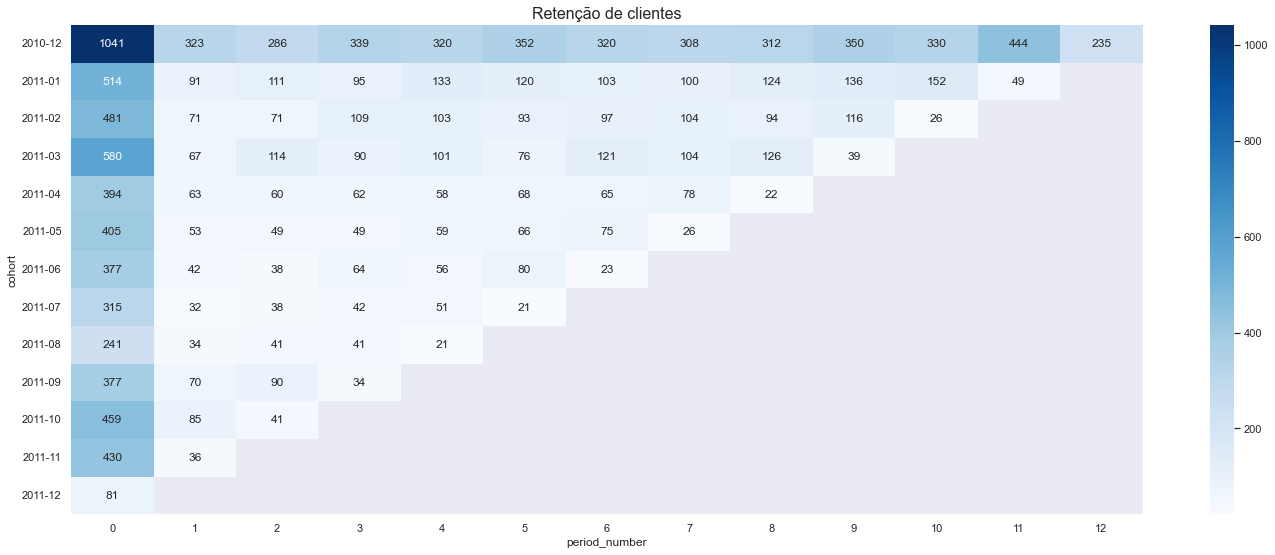

In [54]:
plt.title('Retenção de clientes', fontsize=16)
sns.heatmap(data = cohort_pivot_retention, annot = True, cmap = "Blues", fmt='g');
plt.show();

**Análise do gráfico de Cohort**

Cohort 2010-12 - Linha 1
* No mês de dezembro de 2010 ao todo 1041 clientes realizaram a sua primeira compra no e-commerce. ( Linha 1 x Coluna 0 )
* No mês de janeiro de 2011 apenas 323 dos 1041 clientes voltaram a comprar novamente algum produto nesse mês ( Linha 1 x Coluna 1 )
* O cliente que entrou nesse cohort permanece sendo analisado por 12 meses até dezembro de 2011.

Cohort 2011-10 - Linha 11
* No mês de outubro de 2011 ao todo 459 clientes realizaram a sua primeira compra no e-commerce. ( Linha 11 x Coluna 0 )
* No mês de dezembro de 2011 apenas 41 dos 459 clientes voltaram a comprar novamente algum produto nesse mês ( Linha 11 x Coluna 2 )
* O cliente que entrou nesse cohort permanece sendo analisado por 2 meses até dezembro de 2011.

**Insights**
* As vendas caem cerca de 50% depois do cohort de 2010-12 
* Os piores cohorts com menos entrada de novos clientes foram agosto (2011-08) e dezembro (2011-12) de 2011.

## Cohort Retenção de Clientes em Porcentagem

In [55]:
# getting percentage values
cohort_size_retention = cohort_pivot_retention.iloc[:,0]
retention_matrix = cohort_pivot_retention.divide(cohort_size_retention, axis = 0)

retention_matrix.style.highlight_max(color = 'lightgreen', axis = 0).format('{:.4f}')

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,,
2010-12,1.0000,0.3103,0.2747,0.3256,0.3074,0.3381,0.3074,0.2959,0.2997,0.3362,0.3170,0.4265,0.2257
2011-01,1.0000,0.1770,0.2160,0.1848,0.2588,0.2335,0.2004,0.1946,0.2412,0.2646,0.2957,0.0953,nan
2011-02,1.0000,0.1476,0.1476,0.2266,0.2141,0.1933,0.2017,0.2162,0.1954,0.2412,0.0541,nan,nan
2011-03,1.0000,0.1155,0.1966,0.1552,0.1741,0.1310,0.2086,0.1793,0.2172,0.0672,nan,nan,nan
2011-04,1.0000,0.1599,0.1523,0.1574,0.1472,0.1726,0.1650,0.1980,0.0558,nan,nan,nan,nan
2011-05,1.0000,0.1309,0.1210,0.1210,0.1457,0.1630,0.1852,0.0642,nan,nan,nan,nan,nan
2011-06,1.0000,0.1114,0.1008,0.1698,0.1485,0.2122,0.0610,nan,nan,nan,nan,nan,nan
2011-07,1.0000,0.1016,0.1206,0.1333,0.1619,0.0667,nan,nan,nan,nan,nan,nan,nan
2011-08,1.0000,0.1411,0.1701,0.1701,0.0871,nan,nan,nan,nan,nan,nan,nan,nan


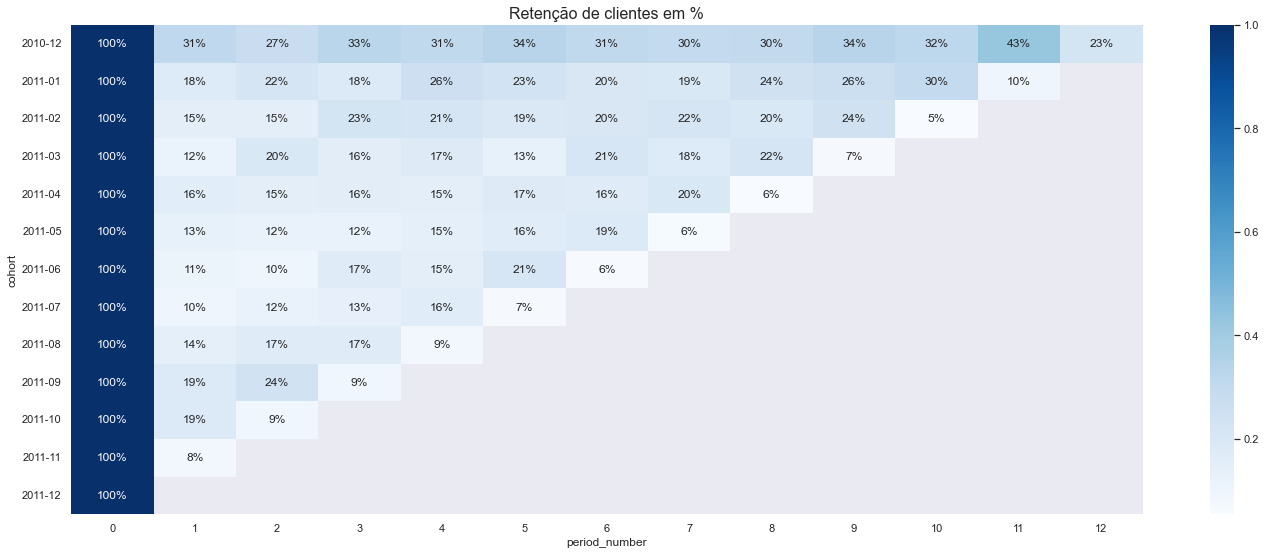

In [56]:
plt.title('Retenção de clientes em %', fontsize=16)
sns.heatmap(data = retention_matrix, annot = True, cmap = "Blues", fmt='.0%');
plt.show();

**Análise do gráfico de Cohort**

Cohort 2010-12 - Linha 1
* No mês de dezembro de 2010 ao todo 1041 clientes realizaram a sua primeira compra no e-commerce e correspondem a 100% do Cohort. ( Linha 1 x Coluna 0 )
* No mês de janeiro de 2011 apenas 31% dos clientes voltaram a comprar novamente algum produto nesse mês ( Linha 1 x Coluna 1 )
* O cliente que entrou nesse cohort permanece sendo analisado por 12 meses até dezembro de 2011.

Cohort 2011-10 - Linha 11
* No mês de outubro de 2011 ao todo 459 clientes realizaram a sua primeira compra no e-commerce e correspondem a 100% do Cohort. ( Linha 11 x Coluna 0 )
* No mês de dezembro de 2011 apenas 19% dos clientes voltaram a comprar novamente algum produto nesse mês ( Linha 11 x Coluna 2 )
* O cliente que entrou nesse cohort permanece sendo analisado por 2 meses até dezembro de 2011.

**Insights**
* O cohort de 2010-12 apresenta a melhor taxa de retenção de clientes ao longo dos meses
* Os piores cohorts com menores taxas de retenção de clientes foram o de julho(2011-07) e novembro (2011-11) de 2011.

## Cohort - Retenção Faturamento Total

In [57]:
cohort_pivot_revenue = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'faturamento_total')

cohort_pivot_revenue.style.highlight_max(color = 'lightgreen', axis = 0).format('{:.2f}')

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,,
2010-12,778623.36,274352.84,232519.78,297653.57,202676.01,326617.15,311859.78,308346.52,327484.75,471069.61,449964.29,509209.39,184541.78
2011-01,397854.57,53284.71,62573.22,64954.61,80064.89,83328.88,69582.40,71542.44,71555.86,104867.41,122267.06,26204.82,nan
2011-02,223346.93,27668.94,39055.57,48102.41,39974.91,33913.33,49603.83,60607.68,55146.33,64278.45,10546.22,nan,nan
2011-03,303995.19,28737.13,58520.80,42444.22,50509.65,39834.81,64626.69,68781.88,70864.04,12868.02,nan,nan,nan
2011-04,180840.39,28649.27,24412.34,23516.67,25899.29,29523.50,28365.65,33940.61,6134.10,nan,nan,nan,nan
2011-05,198677.26,18348.42,20003.64,19010.17,27703.79,32443.10,33007.91,10583.08,nan,nan,nan,nan,nan
2011-06,218485.50,14144.76,13369.40,30258.80,26252.20,40320.93,8141.35,nan,nan,nan,nan,nan,nan
2011-07,167814.01,11259.54,15044.20,17374.47,18992.37,5803.52,nan,nan,nan,nan,nan,nan,nan
2011-08,167450.16,19161.10,31705.64,38973.17,13594.10,nan,nan,nan,nan,nan,nan,nan,nan


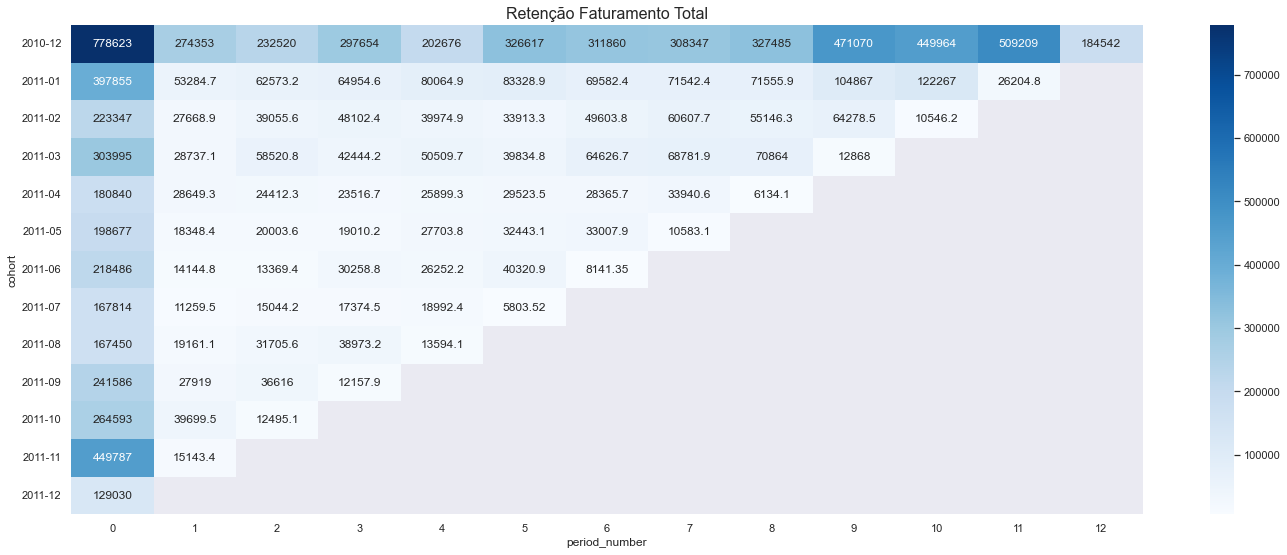

In [58]:
plt.title('Retenção Faturamento Total', fontsize=16)
sns.heatmap(data = cohort_pivot_revenue, annot = True, cmap = "Blues", fmt='g');
plt.show();

**Análise do gráfico de Cohort**

Cohort 2010-12 - Linha 1
* No mês de dezembro de 2010 ao todo 1041 clientes realizaram a sua primeira compra, o que gerou o faturametno total de 778623. ( Linha 1 x Coluna 0 )
* No mês de novembro de 2011, 43% dos clientes voltaram a comprar novamente e faturaram 509209 ( Linha 1 x Coluna 1 )
* O cliente que entrou nesse cohort permanece sendo analisado por 12 meses até dezembro de 2011.

Cohort 2011-08 - Linha 09
* No mês de agosto de 2011 ao todo 241 clientes realizaram a sua primeira compra, o que gerou o faturamento de 167450 . ( Linha 9 x Coluna 0 )
* No mês de dezembro de 2011 apenas 19% dos clientes voltaram a comprar novamente algum produto nesse mês ( Linha 11 x Coluna 2 )
* O cliente que entrou nesse cohort permanece sendo analisado por 4 meses até dezembro de 2011.

**Insights**
* O cohort de 2010-12 apresenta o melhor mês onde os clientes gastaram mais comparando com os demais meses.
* O cohort de 2011-11 apresenta o segundo melhor mês onde os clientes gastaram mais comparando com os demais meses.
* Os piores cohorts em termos de volume de faturamento total correspondem a julho(2011-07) e agosto (2011-08) de 2011.

## Cohort Retenção Faturamento Total em porcentagem

In [59]:
# getting percentage values
cohort_size_revenue = cohort_pivot_revenue.iloc[:,0]
revenue_matrix = cohort_pivot_revenue.divide(cohort_size_revenue, axis = 0)

revenue_matrix.style.highlight_max(color = 'lightgreen', axis = 0).format('{:.5f}')

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,,
2010-12,1.00000,0.35236,0.29863,0.38228,0.26030,0.41948,0.40053,0.39601,0.42059,0.60500,0.57790,0.65399,0.23701
2011-01,1.00000,0.13393,0.15728,0.16326,0.20124,0.20945,0.17489,0.17982,0.17985,0.26358,0.30732,0.06587,nan
2011-02,1.00000,0.12388,0.17487,0.21537,0.17898,0.15184,0.22209,0.27136,0.24691,0.28780,0.04722,nan,nan
2011-03,1.00000,0.09453,0.19251,0.13962,0.16615,0.13104,0.21259,0.22626,0.23311,0.04233,nan,nan,nan
2011-04,1.00000,0.15842,0.13499,0.13004,0.14322,0.16326,0.15685,0.18768,0.03392,nan,nan,nan,nan
2011-05,1.00000,0.09235,0.10068,0.09568,0.13944,0.16330,0.16614,0.05327,nan,nan,nan,nan,nan
2011-06,1.00000,0.06474,0.06119,0.13849,0.12016,0.18455,0.03726,nan,nan,nan,nan,nan,nan
2011-07,1.00000,0.06710,0.08965,0.10353,0.11318,0.03458,nan,nan,nan,nan,nan,nan,nan
2011-08,1.00000,0.11443,0.18934,0.23274,0.08118,nan,nan,nan,nan,nan,nan,nan,nan


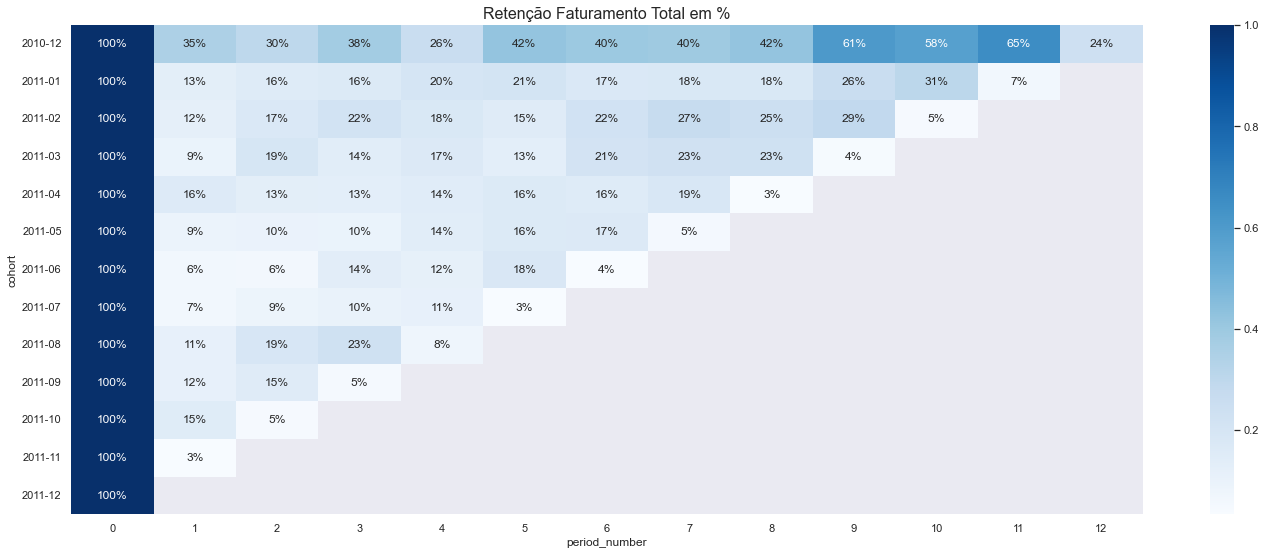

In [60]:
plt.title('Retenção Faturamento Total em %', fontsize=16)
sns.heatmap(data = revenue_matrix, annot = True, cmap = "Blues", fmt='.0%');
plt.show();

**Análise do gráfico de Cohort**

Cohort 2010-12 - Linha 1
* No mês de dezembro de 2010 ao todo 1041 clientes realizaram a sua primeira compra no e-commerce e correspondem a 100% do Cohort. ( Linha 1 x Coluna 0 )
* No mês de abril de 2011 o volume total de vendas correspondeu a 26% do volume total do cohort ( Linha 1 x Coluna 4 )
* O cliente que entrou nesse cohort permanece sendo analisado por 12 meses até dezembro de 2011.

Cohort 2011-06 - Linha 7
* No mês de julho de 2011 o volume total gasto pelos 42 clientes que voltaram comprar representou 6 % do volume total do cohort. ( Linha 7 x Coluna 1 )
* No mês de agosto de 2011 o volume total gasto pelos 36 clientes que voltaram comprar representou 6 % do volume total do cohort. ( Linha 7 x Coluna 2 )
* O cliente que entrou nesse cohort permanece sendo analisado por 6 meses até dezembro de 2011.

**Insights**
* O cohort de 2010-12 apresenta a melhor taxa de faturamento de clientes ao longo dos meses.
* O mês de novembro de 2011 do cohort 2010-12 apresentou um volume de faturamento de 65 % comparado com faturamento total do cohort.( Linha 1 x Coluna 11 )

## Cohort  Faturamento Médio Produto

In [61]:
cohort_pivot_revenue = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'faturamento_medio_produto')

cohort_pivot_revenue.style.highlight_max(color = 'lightgreen', axis = 0).format('{:.2f}')

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,,
2010-12,18.84,27.02,26.57,26.51,20.89,27.18,27.94,27.07,28.78,33.17,33.32,23.13,25.50
2011-01,16.58,24.17,20.74,28.23,22.18,25.85,25.01,25.00,18.96,20.84,19.19,19.20,nan
2011-02,13.95,19.78,20.26,19.29,17.59,16.81,22.13,22.35,18.55,21.91,23.44,nan,nan
2011-03,15.22,20.17,22.48,17.85,20.73,18.87,21.87,19.30,16.55,12.92,nan,nan,nan
2011-04,13.31,20.52,19.36,18.52,19.14,14.55,14.98,15.58,11.86,nan,nan,nan,nan
2011-05,14.39,17.05,21.96,20.80,18.46,13.81,16.73,13.46,nan,nan,nan,nan,nan
2011-06,15.18,15.39,18.94,19.96,14.93,15.59,13.05,nan,nan,nan,nan,nan,nan
2011-07,10.19,23.36,11.35,12.74,10.51,11.12,nan,nan,nan,nan,nan,nan,nan
2011-08,13.65,12.05,11.19,13.95,15.19,nan,nan,nan,nan,nan,nan,nan,nan


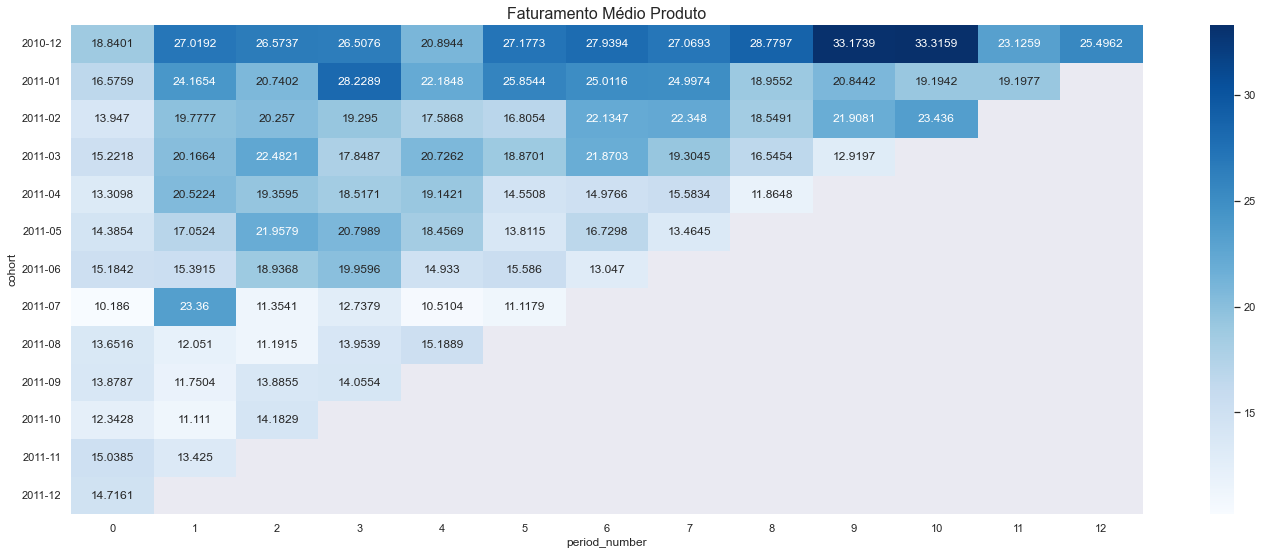

In [62]:
plt.title('Faturamento Médio Produto', fontsize=16)
sns.heatmap(data = cohort_pivot_revenue, annot = True, cmap = "Blues", fmt='g');
plt.show();

**Análise do gráfico de Cohort**

Cohort 2010-12 - Linha 1
* No mês de outubro de 2011 330 clientes do cohort tiveram um ticket médio por produto de 33.31 gerando um faturamento de 449964. ( Linha 1 x Coluna 10 )

Cohort 2011-01 - Linha 2
* Após os 3  primeiros períodos iniciais o ticket médio por produto desse cohort foi maior comparado com os demais cohorts . ( Linha 2 x Coluna 3 )

**Insights**
* O cohort de 2010-12 apresenta o melhor mês onde os clientes gastaram mais em média comparando com os demais meses.
* O cohort de 2011-11 apresentou os menores tickets médio por produto( Linha 12  )

## Cohort Faturamento Mediano Produto

In [63]:
cohort_pivot_revenue = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'faturamento_mediano_produto')

cohort_pivot_revenue.style.highlight_max(color = 'lightgreen', axis = 0).format('{:.2f}')

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,,
2010-12,8.47,13.50,12.50,11.80,10.85,13.05,11.25,10.50,11.90,12.60,13.20,9.96,10.95
2011-01,6.60,10.50,10.00,9.90,12.64,13.52,13.91,11.90,10.50,10.20,8.50,8.50,nan
2011-02,9.78,12.60,12.50,15.00,15.00,13.20,15.00,16.50,13.20,15.00,16.50,nan,nan
2011-03,9.84,15.00,15.00,14.80,15.00,15.00,15.80,14.85,10.08,5.28,nan,nan,nan
2011-04,8.29,15.00,13.52,15.00,14.85,10.50,11.90,10.50,9.75,nan,nan,nan,nan
2011-05,8.29,10.20,15.30,16.50,15.30,10.20,14.04,8.70,nan,nan,nan,nan,nan
2011-06,6.58,8.32,15.00,14.85,10.20,9.75,6.30,nan,nan,nan,nan,nan,nan
2011-07,4.96,15.90,8.25,9.33,5.04,5.05,nan,nan,nan,nan,nan,nan,nan
2011-08,7.46,6.58,7.47,8.29,10.79,nan,nan,nan,nan,nan,nan,nan,nan


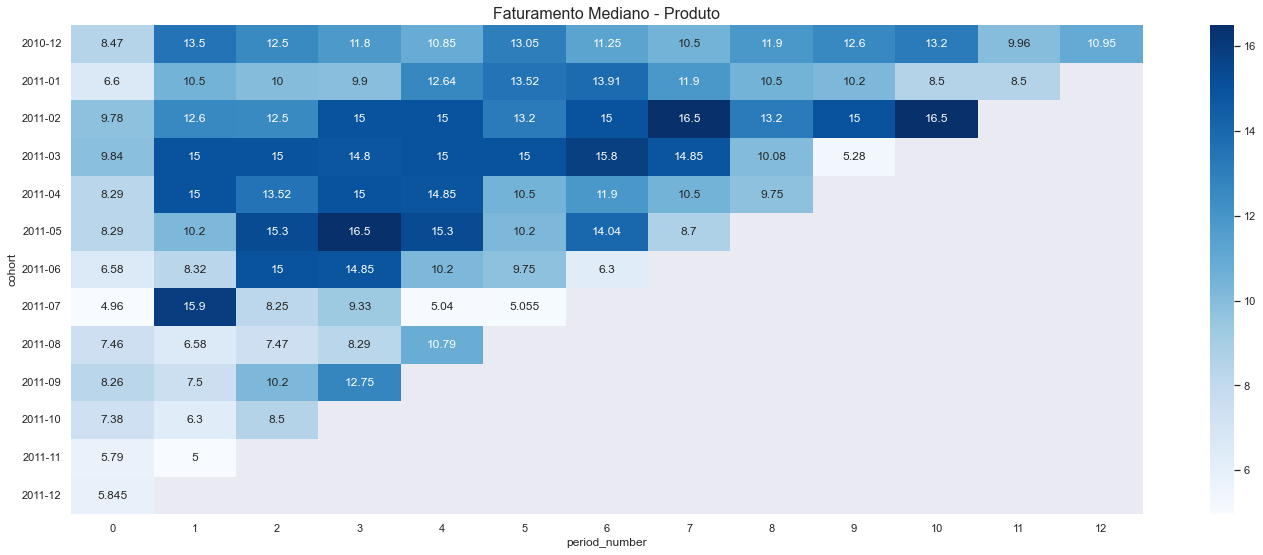

In [64]:
plt.title('Faturamento Mediano - Produto', fontsize=16)
sns.heatmap(data = cohort_pivot_revenue, annot = True, cmap = "Blues", fmt='g');
plt.show();

**Análise do gráfico de Cohort**

Cohort 2011-05 - Linha 6
* No mês de agosto de 2011 o ticket mediano por produto foi o maior comparado com os demais cohorts após 3 períodos. ( Linha 6 x Coluna 3 )

Cohort 2011-07 - Linha 08
* O cohort de julho de 2011 possui o menor ticket mediano para os novos clientes, que corresponde a 4.96. ( Linha 8 x Coluna 0 )

**Insights**
* Os tickets medianos apresentam valores bem menores que os tickets médios por produtos.
* O cohort de julho de 2011 possui os menores tickets medianos comparado aos demais cohorts.

## Cohort Tipos de Produtos

In [65]:
# Quantos tipos de produtos são comprados
cohort_pivot_revenue = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'qty_produtos')

cohort_pivot_revenue.style.highlight_max(color = 'lightgreen', axis = 0).format('{:.2f}')

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,,
2010-12,2783.00,1784.00,1692.00,1828.00,1773.00,1827.00,1852.00,1933.00,1930.00,2125.00,2047.00,2265.00,1750.00
2011-01,2428.00,969.00,1111.00,959.00,1119.00,1176.00,1095.00,1137.00,1309.00,1461.00,1659.00,770.00,nan
2011-02,2181.00,756.00,970.00,976.00,952.00,927.00,964.00,1082.00,1214.00,1150.00,332.00,nan,nan
2011-03,2290.00,762.00,978.00,1002.00,1056.00,982.00,1148.00,1307.00,1357.00,613.00,nan,nan,nan
2011-04,2119.00,726.00,709.00,673.00,735.00,992.00,946.00,968.00,403.00,nan,nan,nan,nan
2011-05,2051.00,653.00,557.00,610.00,825.00,1017.00,926.00,537.00,nan,nan,nan,nan,nan
2011-06,2341.00,631.00,507.00,866.00,946.00,1108.00,448.00,nan,nan,nan,nan,nan,nan
2011-07,2325.00,400.00,809.00,790.00,869.00,404.00,nan,nan,nan,nan,nan,nan,nan
2011-08,2210.00,967.00,1183.00,1169.00,760.00,nan,nan,nan,nan,nan,nan,nan,nan


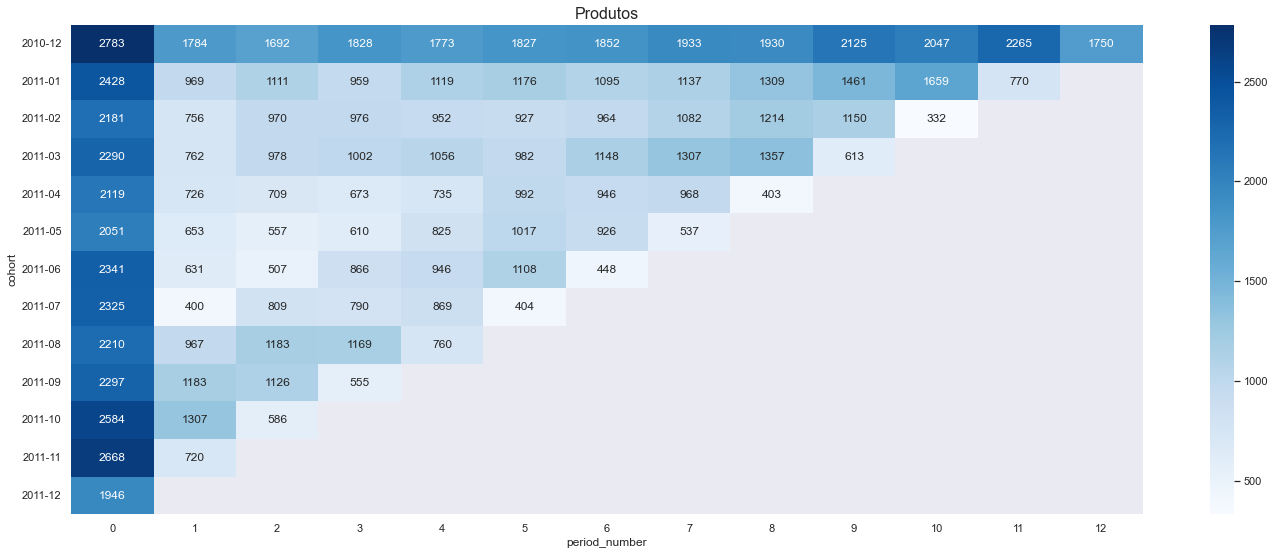

In [66]:
plt.title('Produtos', fontsize=16)
sns.heatmap(data = cohort_pivot_revenue, annot = True, cmap = "Blues", fmt='g');
plt.show();

**Análise do gráfico de Cohort**

Cohort 2010-12 - Linha 1
* No mês de dezembro de 2010 os 1041 clientes compraram ao todo 2783 tipos diferentes de produtos. ( Linha 1 x Coluna 0 )

Cohort 2011-07 - Linha 8
* No mês de agosto de 2011 apenas 400 tipos diferentes de produtos foram comprados pelos 315 clientes que compraram nesse cohort. ( Linha 8 x Coluna 1 )

Cohort 2011-02 - Linha 3
* No mês de dezembro de 2011 apenas 332 tipos diferentes de produtos foram comprados pelos 481 clientes que compraram nesse cohort. ( Linha 3 x Coluna 10 )

**Insight**
* O cohort de 2010-12 apresenta o melhor mês onde os clientes compraram mais tipos de produtos.

## Cohort Média de Itens da cesta

In [67]:
cohort_pivot_revenue = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'media_items_cesta')

cohort_pivot_revenue.style.highlight_max(color = 'lightgreen', axis = 0).format('{:.2f}')

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,,
2010-12,8.68,15.61,15.63,15.80,13.54,14.85,16.00,15.55,18.13,17.59,18.92,13.25,15.17
2011-01,9.54,13.16,12.69,15.22,12.78,15.35,14.94,14.87,11.61,10.55,9.45,9.99,nan
2011-02,7.33,13.65,19.08,12.11,12.30,12.31,13.64,13.42,10.86,12.36,13.41,nan,nan
2011-03,7.12,11.71,13.29,10.11,14.33,12.98,13.41,13.50,11.17,9.47,nan,nan,nan
2011-04,6.51,10.44,9.85,11.87,11.79,8.59,9.90,9.51,7.51,nan,nan,nan,nan
2011-05,6.56,9.66,14.15,12.79,11.19,8.70,10.67,7.57,nan,nan,nan,nan,nan
2011-06,5.96,14.59,10.90,13.61,10.57,9.85,9.45,nan,nan,nan,nan,nan,nan
2011-07,4.87,14.14,7.33,8.09,6.13,7.08,nan,nan,nan,nan,nan,nan,nan
2011-08,5.89,6.21,5.44,6.17,7.08,nan,nan,nan,nan,nan,nan,nan,nan


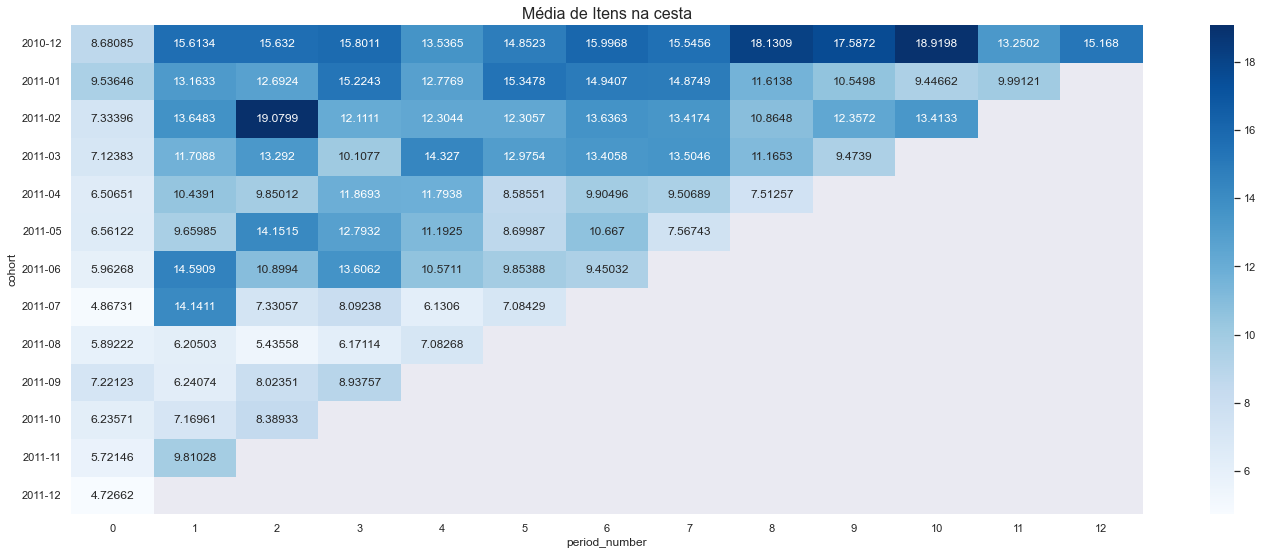

In [68]:
plt.title('Média de Itens na cesta', fontsize=16)
sns.heatmap(data = cohort_pivot_revenue, annot = True, cmap = "Blues", fmt='g');
plt.show();

**Análise do gráfico de Cohort**

Cohort 2010-12 - Linha 1
* No mês de dezembro de 2010 a quantidade média de itens na cesta dos 1041 clientes corresponde a 8.68 itens. ( Linha 1 x Coluna 0 )

Cohort 2011-02 - Linha 3
* No mês de abril de 2011 a quantidade média de itens na cesta dos 481 clientes desse cohort corresponde a 19.07 itens. ( Linha 3 x Coluna 2 )

Cohort 2011-01 - Linha 2
* A quantidade média de itens na cesta  dos primerios clientes desse cohort foi superior aos demais cohorts. ( Linha 2 x Coluna 0 )

## Cohorts Horários de maiores volumes de compras

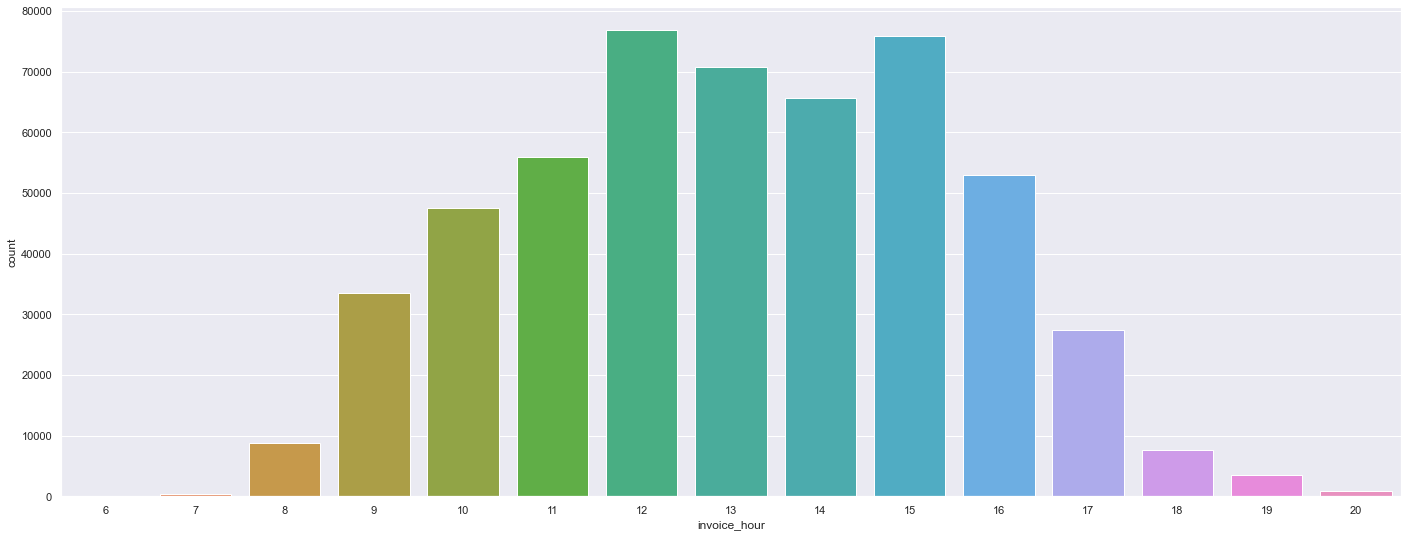

In [69]:
sns.countplot( data = df2_purchases, x ='invoice_hour' );

**Acima mostramos os horários onde ocorrem os maiores volumes de vendas.**

As compras realizadas de 12:00 às 15:59 correspondem a 54.79% do volume total

In [70]:
aux1 = df2_purchases[ ( df2_purchases['invoice_hour'] >= 12) & ( df2_purchases['invoice_hour'] <= 15 ) ].shape[0] / df2_purchases.shape[0]
print('Compras realizadas de 12:00  às 15:59 horas correspondem a {:.2f} % do volume total'.format(aux1*100))

Compras realizadas de 12:00  às 15:59 horas correspondem a 54.79 % do volume total


### Dataframe horários de maior volume de vendas

In [71]:
df_horario = df2_purchases[ ( df2_purchases['invoice_hour'] >= 12) & ( df2_purchases['invoice_hour'] <= 15 ) ]

In [72]:
df_cohort2 = ( df_horario[['customer_id','invoice_month','faturamento_item','period_number','quantity','stock_code','cohort']].groupby(['cohort', 'invoice_month', 'period_number'])
             .agg(qty_clientes = ('customer_id', 'nunique'), 
                  qty_produtos = ('stock_code', 'nunique'), 
                  media_items_cesta = ('quantity', 'mean'), 
                  faturamento_total = ('faturamento_item', 'sum'),
                  faturamento_medio_produto = ('faturamento_item', 'mean'),
                  faturamento_mediano_produto = ('faturamento_item', 'median') ).reset_index() )

### Cohort Retenção de Clientes

In [73]:
cohort_pivot_retention = df_cohort2.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'qty_clientes')

cohort_pivot_retention.style.highlight_max(color = 'lightgreen', axis = 0).format('{:.0f}')

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,,
2010-12,636,207,174,207,182,202,195,195,192,218,207,282,138
2011-01,281,55,67,54,70,73,60,67,78,89,97,28,nan
2011-02,258,40,41,59,53,51,53,65,63,63,13,nan,nan
2011-03,320,41,71,55,56,37,63,62,75,20,nan,nan,nan
2011-04,201,34,24,34,38,41,38,46,15,nan,nan,nan,nan
2011-05,235,28,33,27,37,46,39,15,nan,nan,nan,nan,nan
2011-06,199,19,23,39,36,55,18,nan,nan,nan,nan,nan,nan
2011-07,167,21,30,27,36,10,nan,nan,nan,nan,nan,nan,nan
2011-08,130,18,27,28,10,nan,nan,nan,nan,nan,nan,nan,nan


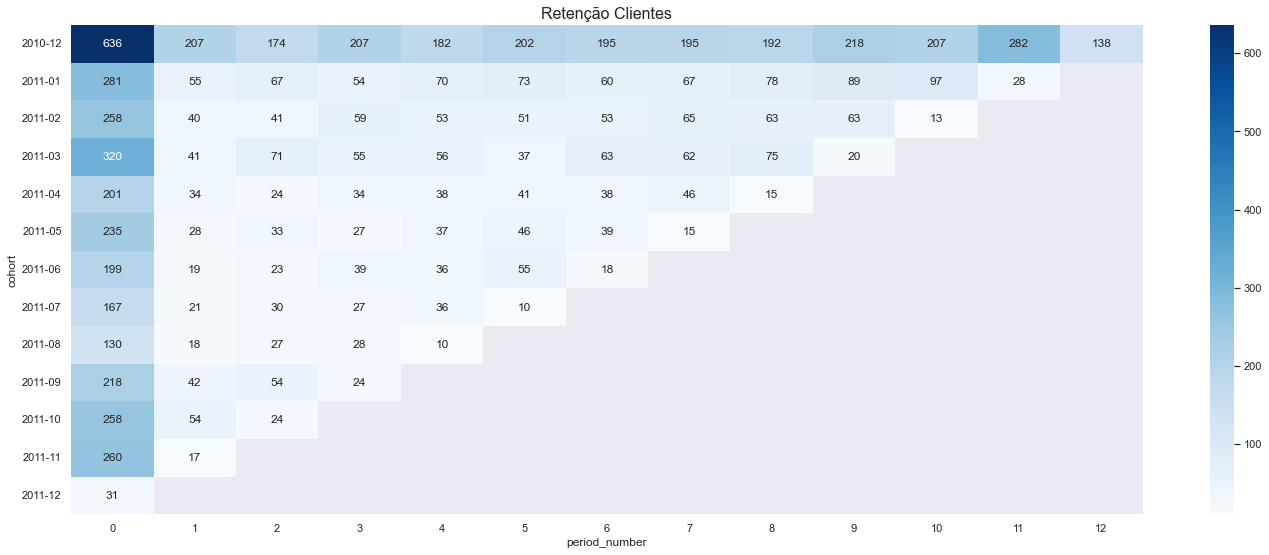

In [74]:
plt.title('Retenção Clientes', fontsize=16)
sns.heatmap(data = cohort_pivot_retention, annot = True, cmap = "Blues", fmt='g');
plt.show();

### Cohort Retenção de Clientes em Porcentagem

In [75]:

cohort_size_retention = cohort_pivot_retention.iloc[:,0]
retention_matrix = cohort_pivot_retention.divide(cohort_size_retention, axis = 0)

retention_matrix.style.highlight_max(color = 'lightgreen', axis = 0).format('{:.4f}')

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,,
2010-12,1.0000,0.3255,0.2736,0.3255,0.2862,0.3176,0.3066,0.3066,0.3019,0.3428,0.3255,0.4434,0.2170
2011-01,1.0000,0.1957,0.2384,0.1922,0.2491,0.2598,0.2135,0.2384,0.2776,0.3167,0.3452,0.0996,nan
2011-02,1.0000,0.1550,0.1589,0.2287,0.2054,0.1977,0.2054,0.2519,0.2442,0.2442,0.0504,nan,nan
2011-03,1.0000,0.1281,0.2219,0.1719,0.1750,0.1156,0.1969,0.1938,0.2344,0.0625,nan,nan,nan
2011-04,1.0000,0.1692,0.1194,0.1692,0.1891,0.2040,0.1891,0.2289,0.0746,nan,nan,nan,nan
2011-05,1.0000,0.1191,0.1404,0.1149,0.1574,0.1957,0.1660,0.0638,nan,nan,nan,nan,nan
2011-06,1.0000,0.0955,0.1156,0.1960,0.1809,0.2764,0.0905,nan,nan,nan,nan,nan,nan
2011-07,1.0000,0.1257,0.1796,0.1617,0.2156,0.0599,nan,nan,nan,nan,nan,nan,nan
2011-08,1.0000,0.1385,0.2077,0.2154,0.0769,nan,nan,nan,nan,nan,nan,nan,nan


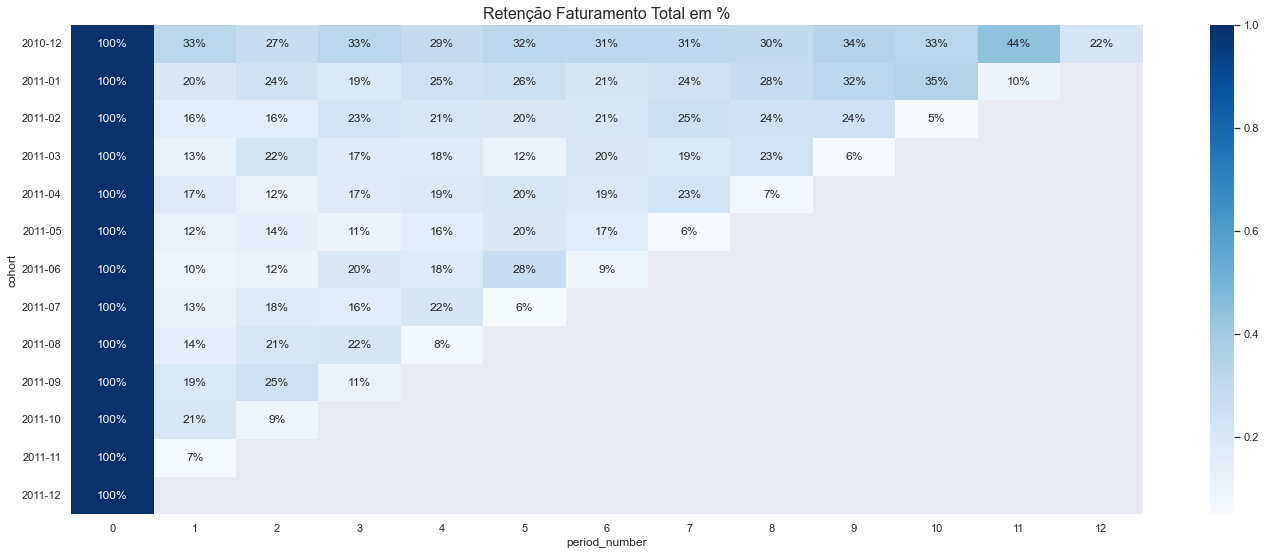

In [76]:
plt.title('Retenção Faturamento Total em %', fontsize=16)
sns.heatmap(data = retention_matrix, annot = True, cmap = "Blues", fmt='.0%');
plt.show();

### Cohort - Retenção Faturamento Total

In [77]:
cohort_pivot_revenue = df_cohort2.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'faturamento_total')

cohort_pivot_revenue.style.highlight_max(color = 'lightgreen', axis = 0).format('{:.2f}')

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,,
2010-12,428433.96,147782.34,113789.73,140807.72,94135.02,138080.84,116057.39,172575.47,167345.83,215333.38,234818.80,226071.10,103421.38
2011-01,184820.83,19853.05,24125.73,40988.95,41756.75,56316.09,39775.72,28712.12,45198.89,73869.05,74532.16,12505.00,nan
2011-02,107253.95,15667.32,20990.67,23464.68,19317.39,15434.17,20401.05,37050.88,38216.68,29026.00,5967.41,nan,nan
2011-03,135235.78,16945.57,36448.18,26296.28,26745.67,18347.99,32325.10,30810.00,37977.99,5880.48,nan,nan,nan
2011-04,85729.60,12291.74,10420.97,10748.77,16453.40,16786.07,16342.13,20469.26,4419.38,nan,nan,nan,nan
2011-05,119746.55,8169.70,11896.09,10517.26,16873.33,21116.31,18147.64,4801.43,nan,nan,nan,nan,nan
2011-06,137209.30,4800.90,7378.34,13204.08,15168.20,24343.96,5893.09,nan,nan,nan,nan,nan,nan
2011-07,70444.76,5458.50,11040.77,10444.29,10391.40,3254.55,nan,nan,nan,nan,nan,nan,nan
2011-08,69539.80,13398.99,19463.35,32222.47,2101.39,nan,nan,nan,nan,nan,nan,nan,nan


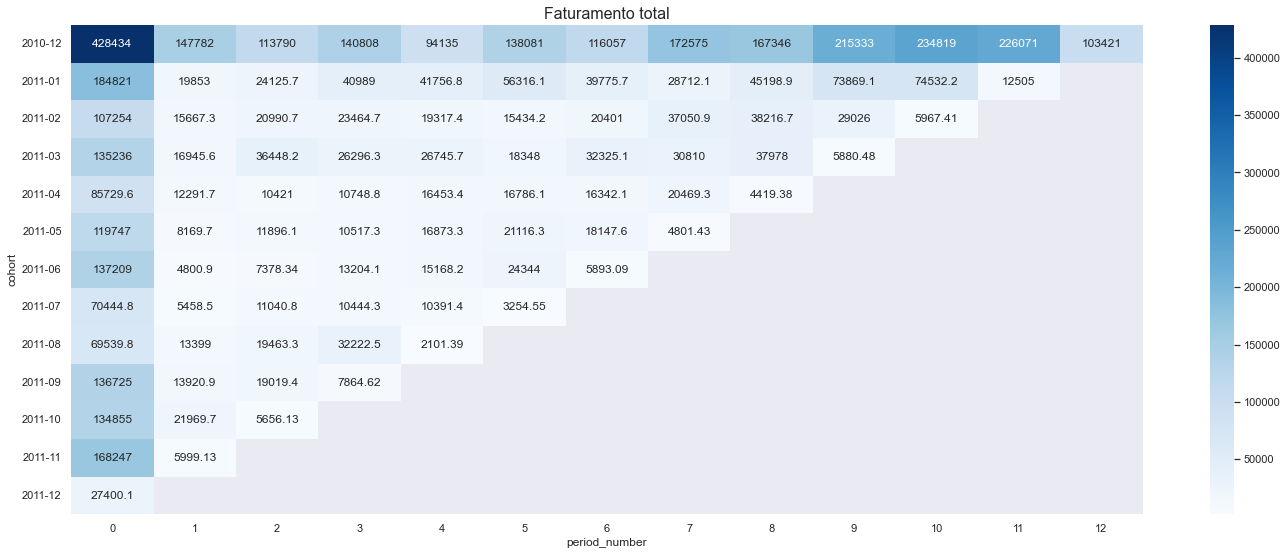

In [78]:
plt.title('Faturamento total', fontsize=16)
sns.heatmap(data = cohort_pivot_revenue, annot = True, cmap = "Blues", fmt='g');
plt.show();

### Cohort Retenção Faturamento Total em porcentagem

In [79]:
# getting percentage values
cohort_size_revenue = cohort_pivot_revenue.iloc[:,0]
revenue_matrix = cohort_pivot_revenue.divide(cohort_size_revenue, axis = 0)

revenue_matrix.style.highlight_max(color = 'lightgreen', axis = 0).format('{:.5f}')

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,,
2010-12,1.00000,0.34494,0.26559,0.32866,0.21972,0.32229,0.27089,0.40281,0.39060,0.50261,0.54809,0.52767,0.24139
2011-01,1.00000,0.10742,0.13054,0.22178,0.22593,0.30471,0.21521,0.15535,0.24456,0.39968,0.40327,0.06766,nan
2011-02,1.00000,0.14608,0.19571,0.21878,0.18011,0.14390,0.19021,0.34545,0.35632,0.27063,0.05564,nan,nan
2011-03,1.00000,0.12530,0.26952,0.19445,0.19777,0.13567,0.23903,0.22782,0.28083,0.04348,nan,nan,nan
2011-04,1.00000,0.14338,0.12156,0.12538,0.19192,0.19580,0.19062,0.23877,0.05155,nan,nan,nan,nan
2011-05,1.00000,0.06822,0.09934,0.08783,0.14091,0.17634,0.15155,0.04010,nan,nan,nan,nan,nan
2011-06,1.00000,0.03499,0.05377,0.09623,0.11055,0.17742,0.04295,nan,nan,nan,nan,nan,nan
2011-07,1.00000,0.07749,0.15673,0.14826,0.14751,0.04620,nan,nan,nan,nan,nan,nan,nan
2011-08,1.00000,0.19268,0.27989,0.46337,0.03022,nan,nan,nan,nan,nan,nan,nan,nan


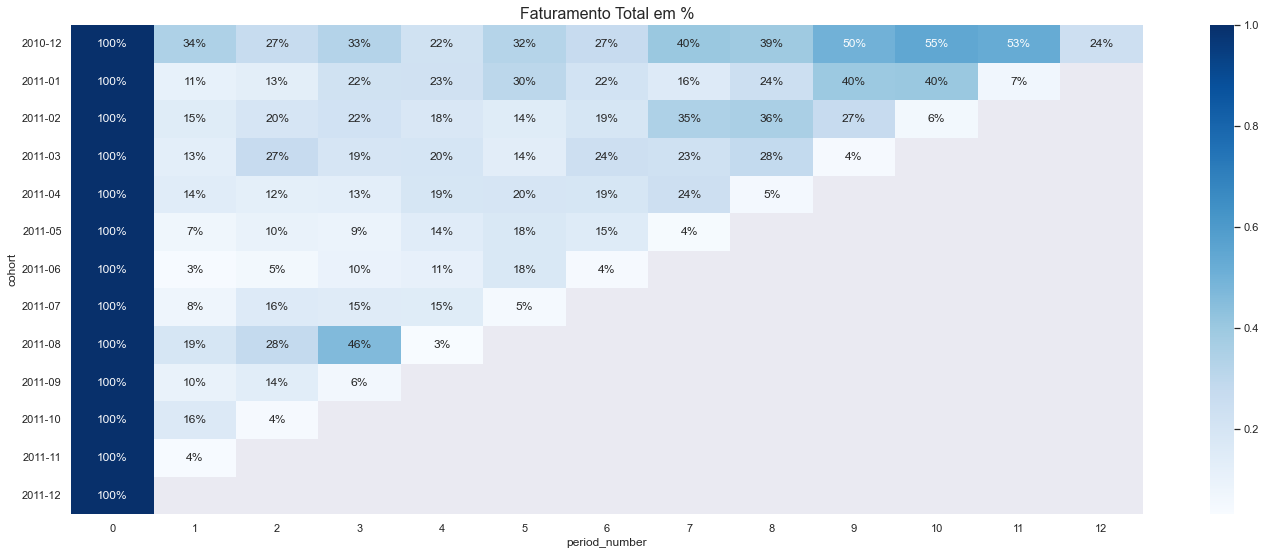

In [80]:
plt.title('Faturamento Total em %', fontsize=16)
sns.heatmap(data = revenue_matrix, annot = True, cmap = "Blues", fmt='.0%');
plt.show();

### Cohort  Faturamento Médio Produto

In [81]:
cohort_pivot_revenue = df_cohort2.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'faturamento_medio_produto')

cohort_pivot_revenue.style.highlight_max(color = 'lightgreen', axis = 0).format('{:.2f}')

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,,
2010-12,18.24,24.54,23.43,21.48,18.17,22.93,18.20,24.40,26.11,24.33,28.68,18.31,25.01
2011-01,14.92,14.67,12.49,38.09,23.35,28.09,24.95,15.27,19.05,20.27,18.09,14.26,nan
2011-02,13.99,18.07,17.67,18.06,16.08,14.15,17.59,21.27,17.25,20.27,27.12,nan,nan
2011-03,13.71,21.84,23.68,17.90,21.64,16.17,19.29,14.79,14.59,8.13,nan,nan,nan
2011-04,12.29,16.17,17.60,19.16,16.36,13.67,15.01,16.04,14.16,nan,nan,nan,nan
2011-05,14.54,11.64,21.36,20.42,19.24,13.10,16.15,8.96,nan,nan,nan,nan,nan
2011-06,18.22,10.57,17.40,15.70,14.15,13.68,11.42,nan,nan,nan,nan,nan,nan
2011-07,11.90,18.26,11.22,10.77,9.43,9.07,nan,nan,nan,nan,nan,nan,nan
2011-08,12.69,9.91,12.23,13.23,14.39,nan,nan,nan,nan,nan,nan,nan,nan


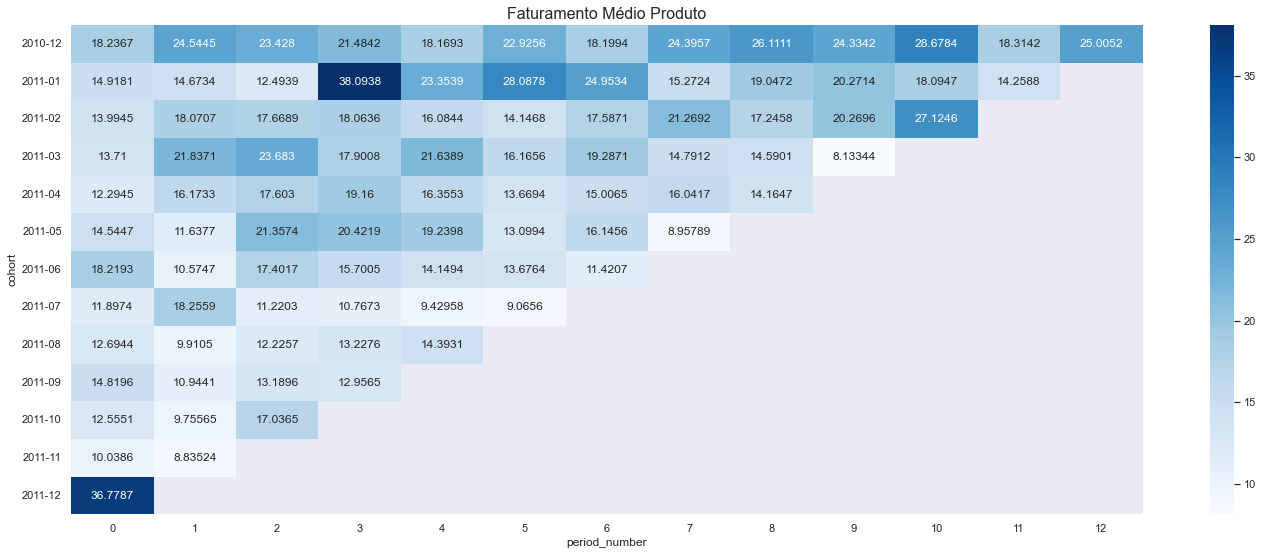

In [82]:
plt.title('Faturamento Médio Produto', fontsize=16)
sns.heatmap(data = cohort_pivot_revenue, annot = True, cmap = "Blues", fmt='g');
plt.show();

### Cohort Faturamento Mediano Produto

In [83]:
cohort_pivot_revenue = df_cohort2.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'faturamento_mediano_produto')

cohort_pivot_revenue.style.highlight_max(color = 'lightgreen', axis = 0).format('{:.2f}')

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,,
2010-12,8.42,12.50,10.50,10.20,10.14,10.20,9.90,10.00,10.40,10.50,10.50,8.40,10.08
2011-01,7.46,9.90,7.95,10.20,12.50,13.40,12.50,9.90,10.20,10.00,7.50,6.60,nan
2011-02,9.95,10.20,9.90,15.00,10.08,9.96,15.00,15.80,10.50,13.51,16.50,nan,nan
2011-03,8.32,15.00,15.00,13.20,15.00,15.00,15.00,10.90,8.32,3.75,nan,nan,nan
2011-04,8.26,11.70,10.08,15.00,10.70,8.50,12.60,12.60,12.49,nan,nan,nan,nan
2011-05,8.29,5.79,15.90,16.50,15.60,9.90,12.48,4.41,nan,nan,nan,nan,nan
2011-06,6.80,6.78,13.20,10.08,6.64,6.78,6.28,nan,nan,nan,nan,nan,nan
2011-07,6.58,15.30,6.25,7.50,4.68,4.16,nan,nan,nan,nan,nan,nan,nan
2011-08,7.46,5.79,8.50,7.48,15.00,nan,nan,nan,nan,nan,nan,nan,nan


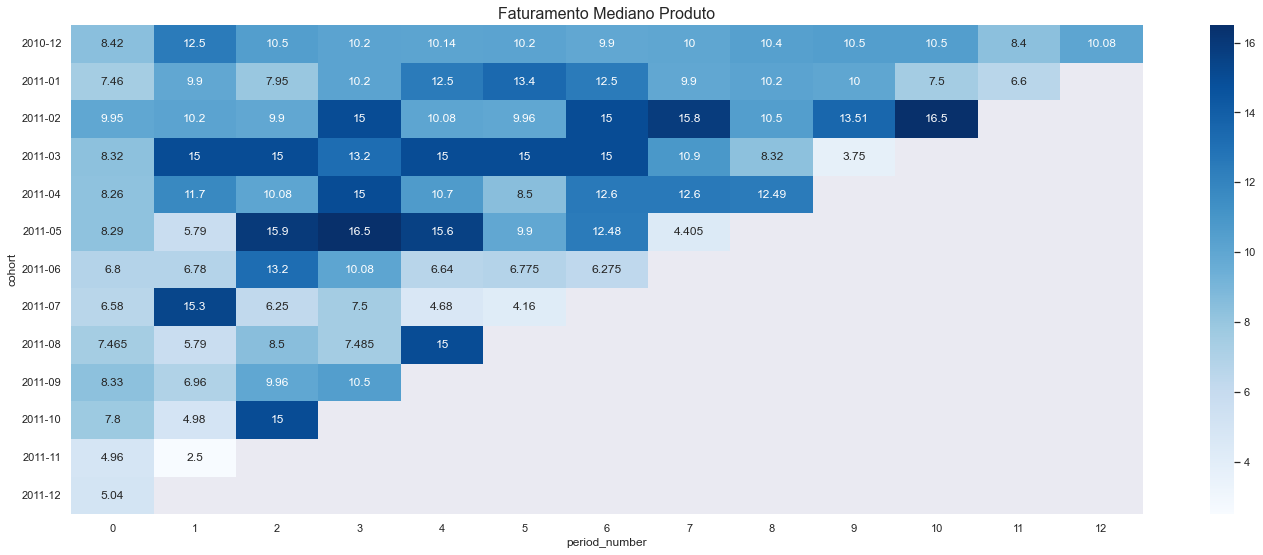

In [84]:
plt.title('Faturamento Mediano Produto', fontsize=16)
sns.heatmap(data = cohort_pivot_revenue, annot = True, cmap = "Blues", fmt='g');
plt.show();

### Cohort Tipos de Produtos

In [85]:
# Quantos tipos de produtos são comprados
cohort_pivot_revenue = df_cohort2.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'qty_produtos')

cohort_pivot_revenue.style.highlight_max(color = 'lightgreen', axis = 0).format('{:.2f}')

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,,
2010-12,2553.00,1548.00,1443.00,1588.00,1476.00,1464.00,1595.00,1672.00,1638.00,1915.00,1849.00,2009.00,1425.00
2011-01,2120.00,729.00,903.00,628.00,828.00,954.00,812.00,915.00,1080.00,1300.00,1394.00,580.00,nan
2011-02,1800.00,568.00,743.00,684.00,731.00,654.00,649.00,863.00,1047.00,791.00,182.00,nan,nan
2011-03,1934.00,487.00,759.00,778.00,705.00,709.00,848.00,1033.00,1048.00,514.00,nan,nan,nan
2011-04,1768.00,472.00,414.00,388.00,608.00,730.00,685.00,711.00,257.00,nan,nan,nan,nan
2011-05,1737.00,475.00,409.00,398.00,577.00,841.00,694.00,403.00,nan,nan,nan,nan,nan
2011-06,2008.00,369.00,345.00,594.00,702.00,881.00,379.00,nan,nan,nan,nan,nan,nan
2011-07,1805.00,267.00,681.00,649.00,661.00,292.00,nan,nan,nan,nan,nan,nan,nan
2011-08,1708.00,849.00,960.00,1056.00,133.00,nan,nan,nan,nan,nan,nan,nan,nan


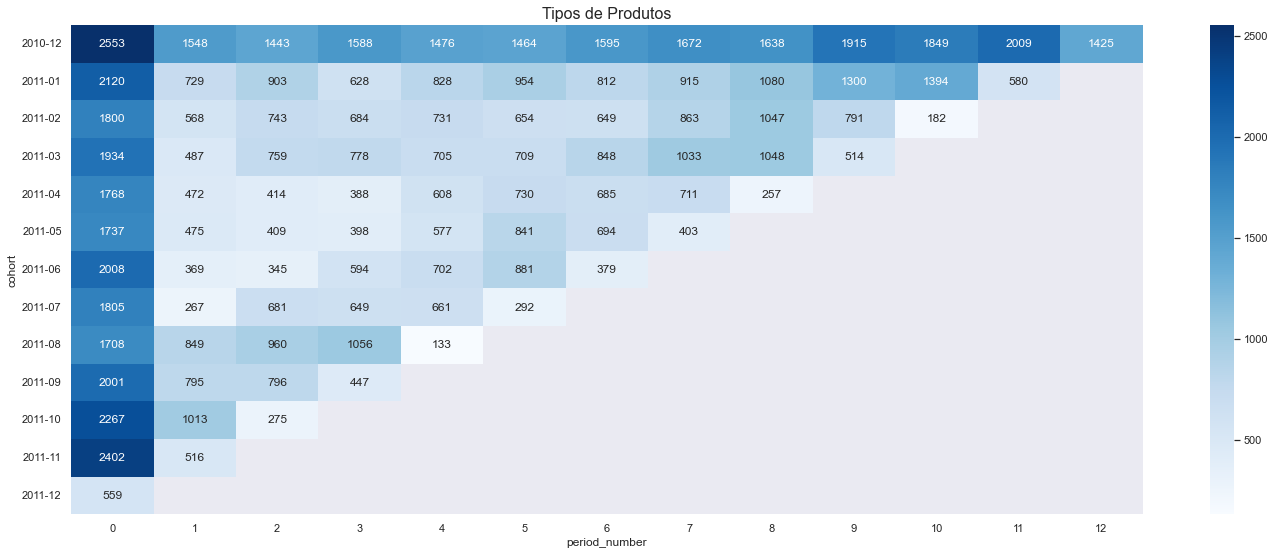

In [86]:
plt.title('Tipos de Produtos', fontsize=16)
sns.heatmap(data = cohort_pivot_revenue, annot = True, cmap = "Blues", fmt='g');
plt.show();

### Cohort Média de Itens da cesta

In [87]:
cohort_pivot_revenue = df_cohort2.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'media_items_cesta')

cohort_pivot_revenue.style.highlight_max(color = 'lightgreen', axis = 0).format('{:.2f}')

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,,
2010-12,8.15,13.86,13.84,13.64,11.72,12.37,10.59,14.77,16.27,12.79,15.96,10.43,15.12
2011-01,7.11,7.52,7.45,19.10,13.55,18.02,15.46,10.10,11.15,10.01,8.34,7.83,nan
2011-02,7.19,13.21,14.98,11.43,12.87,10.35,11.94,12.80,10.37,12.18,16.00,nan,nan
2011-03,6.98,12.90,14.89,9.86,14.31,10.03,12.17,11.10,9.25,5.02,nan,nan,nan
2011-04,6.80,8.73,9.27,10.74,9.75,8.12,10.04,9.77,8.08,nan,nan,nan,nan
2011-05,6.39,6.84,13.22,13.31,12.24,8.02,10.37,5.30,nan,nan,nan,nan,nan
2011-06,5.72,8.54,9.34,12.86,9.79,8.24,8.38,nan,nan,nan,nan,nan,nan
2011-07,6.06,10.04,6.98,6.84,5.69,5.92,nan,nan,nan,nan,nan,nan,nan
2011-08,6.08,4.51,6.52,5.06,9.51,nan,nan,nan,nan,nan,nan,nan,nan


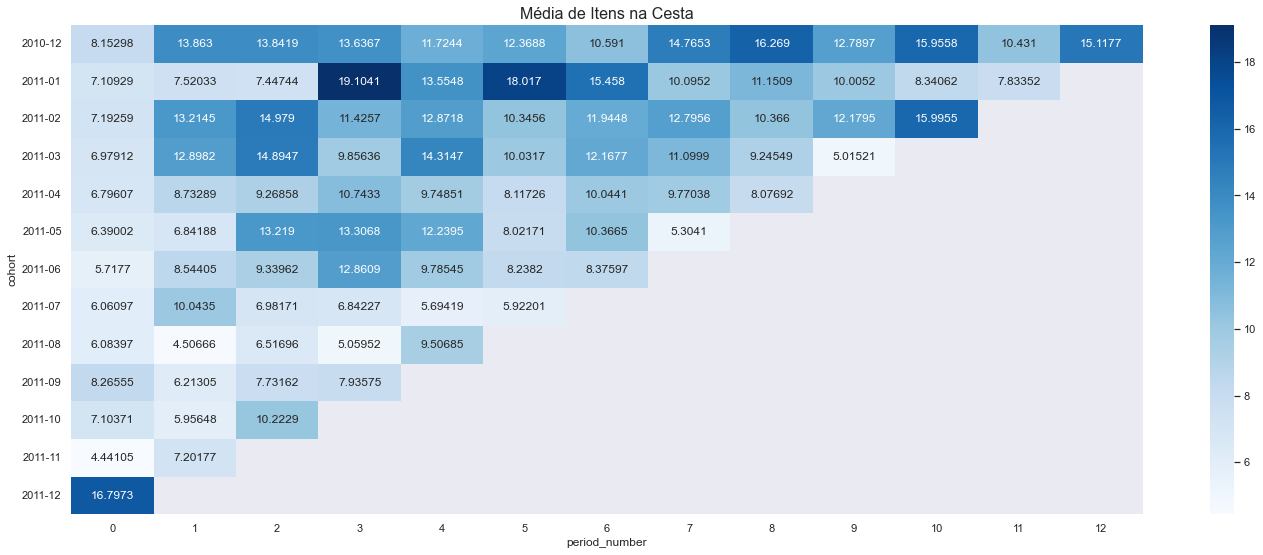

In [88]:
plt.title('Média de Itens na Cesta', fontsize=16)
sns.heatmap(data = cohort_pivot_revenue, annot = True, cmap = "Blues", fmt='g');
plt.show();